# Generative Adversial Network for MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from matplotlib import pyplot as plt

## Model

In [2]:
z_dim = 50
class Discriminator(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(1, 8, 5, stride=2, padding=2)
        self.c2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.l1 = nn.Linear(16 * 7 * 7, 1)
    def forward(self, x):
        y = self.c1(x).relu()
        y = self.c2(y).relu()
        y = y.flatten(start_dim=1)
        return self.l1(y).sigmoid()
class Generator(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(z_dim, 16 * 7 * 7)
        self.tc2 = nn.ConvTranspose2d(16, 8, 5, stride=2, padding=2)
        self.tc1 = nn.ConvTranspose2d(8, 1, 5, stride=2, padding=2)
    def forward(self, y):
        x = self.l1(y).relu()
        x = x.reshape(-1, 16, 7, 7)
        x = self.tc2(x, output_size=(None, 4, 14, 14)).relu()
        x = self.tc1(x, output_size=(None, 1, 28, 28))
        return x.sigmoid()

In [3]:
# use device if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using Device:", device)
# create models
discriminator = Discriminator().to(device)
generator = Generator().to(device)
# create optimizers
discriminator_optim = torch.optim.Adam(discriminator.parameters())
generator_optim = torch.optim.Adam(generator.parameters())

Using Device: cuda:0


## Training

In [4]:
# load mnist data
mnist_train = MNIST('./data/', train=True, download=True, transform=ToTensor())
mnist_test = MNIST('./data/', train=False, download=True, transform=ToTensor())
# create dataloaders
mnist_train = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)
mnist_test = torch.utils.data.DataLoader(mnist_test, shuffle=False, batch_size=64)

Train: 100%|██████████| 7050/7050 [05:24<00:00, 21.69it/s, gloss=1.59, dloss=0.818]


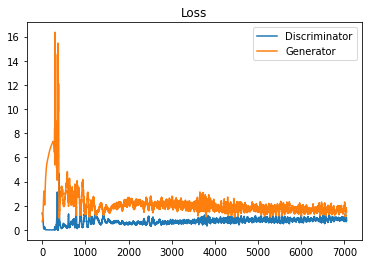

In [5]:
# training the auto-encoder
epochs = 30
n_mean = lambda l, n: sum(l[-n:]) / min(n, len(l))
with tqdm(total=len(mnist_train) * epochs) as pbar:
    pbar.set_description("Train", refresh=True)
    # train
    d_losses, g_losses = [], []
    for e in range(epochs):
        for real_x, _ in mnist_train:

            # prepare real and fake input
            real_x = real_x.to(device)
            fake_x = generator(torch.randn((real_x.size(0), z_dim), device=device))
            
            # train discriminator
            discriminator.train()
            generator.eval()
            # generate fake inputs with generator model
            # train discriminator to seperate fake inputs from the real ones
            real_y = discriminator(real_x)
            fake_y = discriminator(fake_x.detach())
            # compute losses
            dloss_r = F.binary_cross_entropy(real_y, torch.ones_like(real_y))
            dloss_f = F.binary_cross_entropy(fake_y, torch.zeros_like(fake_y))
            dloss = dloss_r + dloss_f
            # update parameters
            discriminator_optim.zero_grad()
            dloss.backward()
            discriminator_optim.step()

            # train generator
            discriminator.eval()
            generator.train()
            # build fake inputs and train to fool the discriminator in the futur
            # consider the loss of the fake inputs being classified as real by the discriminator
            fake_y = discriminator(fake_x)
            gloss = F.binary_cross_entropy(fake_y, torch.ones_like(fake_y))
            # then updating only the generator weights
            generator_optim.zero_grad()
            gloss.backward()
            generator_optim.step()

            # progress
            g_losses.append(gloss.item())
            d_losses.append(dloss.item())
            pbar.set_postfix({'gloss': n_mean(g_losses, 20), 'dloss': n_mean(d_losses, 20)})
            pbar.update(1)


# plot losses
plt.plot(d_losses)
plt.plot(g_losses)
plt.legend(['Discriminator', 'Generator'])
plt.title("Loss")
plt.show()

## Generating

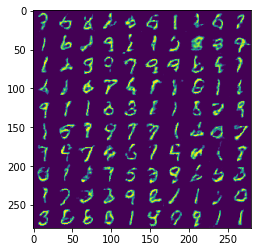

In [7]:
n = 10
# gerenate from random
generator.eval()
with torch.no_grad():
    x = generator(torch.randn(n*n, z_dim, device=device))
    x = x.cpu().numpy()
# transform for visualization
x = x.reshape(n, n, 28, 28)
x = x.transpose(0, 2, 1, 3)
x = x.reshape(n * 28, n * 28)
# visualize
plt.imshow(x)
plt.show()